1.	Обучите нейронную сеть любой архитектуры, которой не было на курсе, либо нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ того, что вам помогло в улучшения работы нейронной сети.


* датасет fashion_mnist
* модель Variational AutoEncoder (VAE)
* слои энкодера Conv2D 32 > Conv2D 64 > > Flatten > Dense 16
* слои декодера Dense 64 > Reshape 64 > Conv2DT 64 > Conv2DT 32 > Conv2DT 1
* оптимизатор Adam
* 30 эпох

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


C:\Users\User\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### sampling layer

In [2]:
 class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a unit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs  # с двумя параметрами на входе
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1] # определяем размер нашего пространства
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim)) # строим шум
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon # восстанавливаем пакет единиц информации, опираясь на параметры нашего распределения



### encoder


In [3]:
latent_dim = 2 

encoder_inputs = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)

x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
# получилась модель: на входе картинка, на выходе 3 тензора
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

###  decoder


In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))

x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)

x = layers.Reshape((7, 7, 64))(x)

x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x) # 14x14
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x) # 28x28
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x) # одноканальная картинка 28x28
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

### Создаем класс с особым шагом обучения train_step


In [5]:
# создаем модель как наследник класса Model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data): # меняем на свое обучение функцию train_step
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape: 
            z_mean, z_log_var, z = encoder(data) 
            reconstruction = decoder(z) 
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5 
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights) 
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

###  VAE


In [6]:
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data() 
mnist_units = np.concatenate([x_train, x_test], axis=0)
mnist_units = np.expand_dims(mnist_units, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam()) 
vae.fit(mnist_units, epochs=30, batch_size=128) 

Epoch 1/30
547/547 [==============================] - 53s 94ms/step - loss: 332.7280 - reconstruction_loss: 329.0174 - kl_loss: 3.7107
Epoch 2/30
547/547 [==============================] - 55s 100ms/step - loss: 297.8286 - reconstruction_loss: 295.3272 - kl_loss: 2.5014
Epoch 3/30
547/547 [==============================] - 53s 98ms/step - loss: 273.3321 - reconstruction_loss: 269.5995 - kl_loss: 3.7327
Epoch 4/30
547/547 [==============================] - 52s 96ms/step - loss: 265.3733 - reconstruction_loss: 261.6841 - kl_loss: 3.6892
Epoch 5/30
547/547 [==============================] - 54s 98ms/step - loss: 263.7293 - reconstruction_loss: 260.1092 - kl_loss: 3.6201
Epoch 6/30
547/547 [==============================] - 55s 101ms/step - loss: 262.6086 - reconstruction_loss: 259.0055 - kl_loss: 3.6031
Epoch 7/30
547/547 [==============================] - 56s 102ms/step - loss: 261.7612 - reconstruction_loss: 258.1654 - kl_loss: 3.5959
Epoch 8/30
547/547 [==============================] 

### Посмотрим на кластеры в скрытом пространстве для одежды


1875/1875 [==============================] - 6s 3ms/step


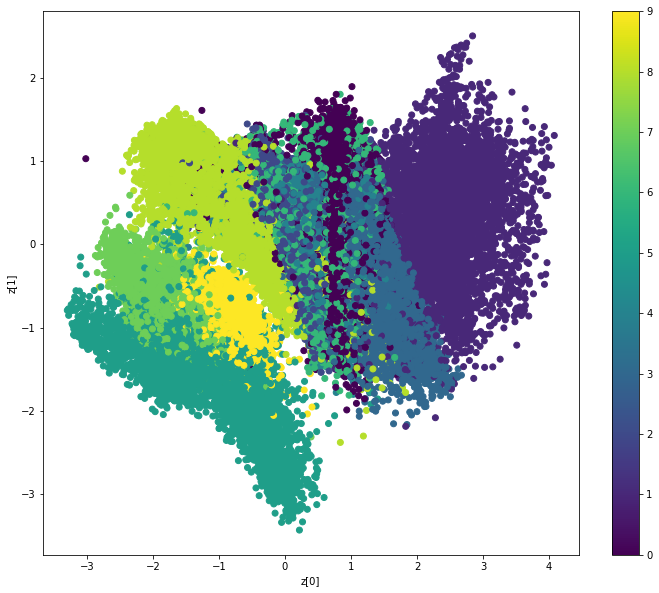

In [11]:

def plot_label_clusters(encoder, data, labels):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, x_train, y_train)


Построим немного примеров генерации одежды:

для этого не нужен энкодер
работа этой модели требует:
- выбрать случайные значения для точки скрытого пространства (2 координаты (среднее и логарифм от дисперсиии) - для построения в n (в нашем случае 28х28) координаты нового образца )
- подать их в декодер
- визуализировать результат

1/1 [==============================] - 0s 19ms/step


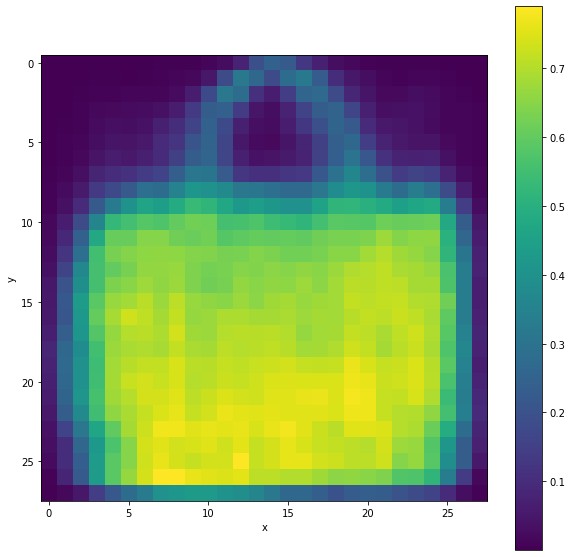

In [12]:

def plot_unit_from_decoder(decoder, z, unit_size):
    
    data = np.array([[z[0], z[1]]])
    unit = decoder.predict(data)
    unit = unit.reshape(unit_size, unit_size)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(unit)
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()



plot_unit_from_decoder(decoder, [-0.5,0.2], 28)

2. Сделайте краткий обзор научной работы, посвящённой алгоритму нейронных сетей, не рассматриваемому ранее на курсе. Проведите анализ: чем отличается выбранная архитектура от других? В чём плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при её применении на практике?

В научной работе Large Scale GAN Training for High Fidelity Natural Image Synthesis авторы Эндрю Брок, 
Джефф Донахью, Карен Симонян предлагают модель BigGAN.

BigGAN является одним из видов генеративных соревновательных сетей, разработана для 
масштабирования генерации изображений с высоким разрешением и высокой достоверностью. Она 
включает ряд изменений и нововведений, а именно:

• Использование SAGAN в качестве базового решения со спектральной нормализацией для G и D, и 
использование TTUR.

• Использование Hinge Loss

• Использование классово-обусловленной пакетной нормализации для предоставления 
информации о классе в G (но с линейной проекцией не MLP)

• Использование проекционного дискриминатора для D для предоставления информации о классе в
D.

• Оценка с помощью EWMA весов G, как в ProGANs.


К числу новшеств относятся:

• Увеличение batch size, что существенно влияет на Inception Score модели.

• Увеличение ширины каждого слоя приводит к дальнейшему улучшению Inception Score.

• Добавление пропускающих соединений от латентной переменной z в последующие уровни 
помогает производительности.

• Новый вариант ортогональной регуляризации.

Модель способна генерировать очень впечатляющие изображения с высокой точностью. При 
обучении на наборе данных ImageNet с разрешением 128х128, BigGAN может достичь Inception Score (IS) 
166.3, что более чем на 100% лучше предыдущего результата (SotA) 52.52. Балл стартового расстояния 
Frechet (FID) также улучшился с 18,65 до 9,6.

Высокий Inception Score означает, что GAN может генерировать много разнообразных отличимых 
изображений. Однако Inception Score имеет ограничения, которые важно знать.

1) Если генерировать что-то, не присутствующее в тренировочных данных (например, акул нет в ILSVRC 
2014), то всегда можно получить низкий IS, несмотря на генерацию высококачественных изображений, 
поскольку это изображение не классифицируется как отдельный класс.

2) Если вы генерируете изображения с другим набором лейблов из тренировочного набора (скажем, 
вы тренируете GAN для создания различных разновидностей пуделей, или только слонов и муравьев), то 
IS может быть низким.

З) Если сеть не может обнаружить признаки, относящиеся к вашей концепции качества изображения 
(например, есть доказательства того, что CNNs сильно полагаются на локальные текстуры изображений для 
классификации, и грубые формы не имеют большого значения), то изображения низкого качества могут 
получить высокие оценки. Например, сеть может создать людей с двумя головами и не получит наказание 
за это.

4) Если генератор генерирует только одно изображение из класса изображений, повторяя каждое 
изображение много раз, он может дать высокий IS (т.е. нет никакой меры внутриклассового разнообразия)

5) Если генератор запомнит тренировочные данные и реплицирует их, он может получить высокий IS